# Analyse de la qualité de l'air à Grenoble

Ce document présente une tentative d'analyse de l'évolution de la qualité de l'air dans différentes villes de la région Rhône-Alpes Auvergne.

Les analyses ci-dessous ont été réalisées avec le langage de programmation R et les bibliothèques suivantes :

In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(lubridate)
library(patchwork)
library(zoo)
library(ggrepel)
options(repr.plot.width=12, repr.plot.height=8)
R.version.string


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



[1] "R version 3.5.2 (2018-12-20)"

## Récupération et nettoyage des données

Toutes les données ont été récupérées sur le site d'[Atmo](https://www.atmo-auvergnerhonealpes.fr/donnees/telecharger) en remplissant le formulaire. Les différents fichiers ainsi téléchargés se trouvent dans le dossier [data](data).

Atmo distingue les stations en différent types (liste non exhaustive) :
- Urbaine/Fond (ex: Grenoble les Frenes)
- Urbaine/Trafic (ex: Grenoble Grands Boulevards)
- Périurbaine/Trafic (ex: Grenoble Rocade Sud)

Le format de données est particulièrement pénible, une colonne par date. On va d'abord restructurer ça pour avoir une observation par ligne. On convertit également les colonnes `Date` et `Valeur` dans les types adéquats.

In [2]:
filename = 'data/region_2008-2019_daily.csv'
df = read.csv(filename, sep=';') %>%
    mutate_all(as.character) %>%
    pivot_longer(c(-Station, -Polluant, -Mesure, -Unité), names_to="raw_date", values_to="Valeur", names_prefix="X") %>%
    mutate(Date=parse_date_time(raw_date, "dmy"), Valeur=as.numeric(sub(",", ".", Valeur)))
str(df)
head(df)

Warning message:
“NAs introduits lors de la conversion automatique”

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	87660 obs. of  7 variables:
 $ Station : chr  "Grenoble les Frenes" "Grenoble les Frenes" "Grenoble les Frenes" "Grenoble les Frenes" ...
 $ Polluant: chr  "Dioxyde d'azote" "Dioxyde d'azote" "Dioxyde d'azote" "Dioxyde d'azote" ...
 $ Mesure  : chr  "Dioxyde d'azote" "Dioxyde d'azote" "Dioxyde d'azote" "Dioxyde d'azote" ...
 $ Unité   : chr  "microg/m3" "microg/m3" "microg/m3" "microg/m3" ...
 $ raw_date: chr  "01.01.2008" "02.01.2008" "03.01.2008" "04.01.2008" ...
 $ Valeur  : num  33 39 40 65 38 27 41 43 41 42 ...
 $ Date    : POSIXct, format: "2008-01-01" "2008-01-02" ...


Station,Polluant,Mesure,Unité,raw_date,Valeur,Date
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dttm>
Grenoble les Frenes,Dioxyde d'azote,Dioxyde d'azote,microg/m3,01.01.2008,33,2008-01-01
Grenoble les Frenes,Dioxyde d'azote,Dioxyde d'azote,microg/m3,02.01.2008,39,2008-01-02
Grenoble les Frenes,Dioxyde d'azote,Dioxyde d'azote,microg/m3,03.01.2008,40,2008-01-03
Grenoble les Frenes,Dioxyde d'azote,Dioxyde d'azote,microg/m3,04.01.2008,65,2008-01-04
Grenoble les Frenes,Dioxyde d'azote,Dioxyde d'azote,microg/m3,05.01.2008,38,2008-01-05
Grenoble les Frenes,Dioxyde d'azote,Dioxyde d'azote,microg/m3,06.01.2008,27,2008-01-06


In [3]:
df %>% group_by(Station, Mesure) %>% count()

Station,Mesure,n
<chr>,<chr>,<int>
Clermont-Fd Montferrand,25CMFD,4383
Clermont-Fd Montferrand,FDCMFD,4383
Clermont-Fd Montferrand,NO2MFD,4383
Clermont-Fd Montferrand,NOMFD,4383
Clermont-Fd Montferrand,O3MFD,4383
Grenoble les Frenes,Dioxyde d'azote,4383
Grenoble les Frenes,Monoxyde d'azote,4383
Grenoble les Frenes,Ozone,4383
Grenoble les Frenes,Particules PM10,4383


On voit qu'il y a des intitulés différents pour certains polluants. On les renomme pour standardiser un peu.

In [4]:
df = df %>%
    mutate(Mesure=ifelse(grepl("25CMFD", Mesure), "Particules PM2.5", Mesure)) %>%
    mutate(Mesure=ifelse(grepl("FDCMFD", Mesure), "Particules PM10", Mesure)) %>%
    mutate(Mesure=ifelse(grepl("NO2MFD", Mesure), "Dioxyde d'azote", Mesure)) %>%
    mutate(Mesure=ifelse(grepl("NOMFD", Mesure),  "Monoxyde d'azote", Mesure)) %>%
    mutate(Mesure=ifelse(grepl("O3MFD", Mesure),  "Ozone", Mesure))

df %>% group_by(Mesure) %>% count()

Mesure,n
<chr>,<int>
Dioxyde d'azote,17532
Monoxyde d'azote,17532
Ozone,17532
Particules PM10,17532
Particules PM2.5,17532


Un certain nombre de valeurs sont manquantes. On commence par regarder si elles ont une distribution particulière.

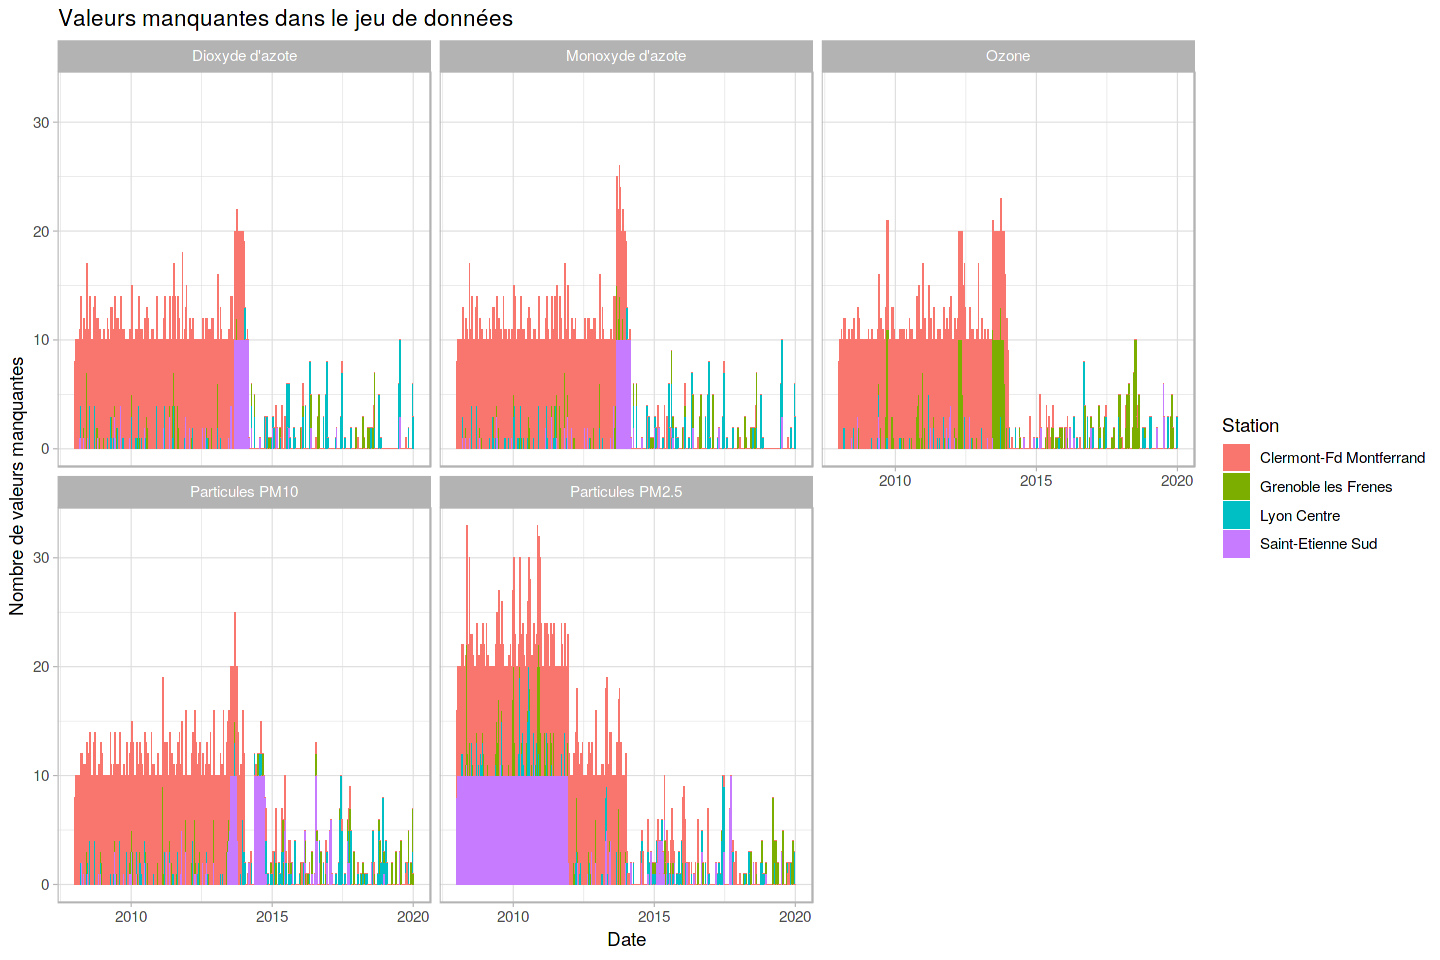

In [5]:
nb_days = as.numeric(max(df$Date) - min(df$Date))
df %>%
    filter(is.na(Valeur)) %>%
    ggplot() +
    aes(x=Date, fill=Station) +
    facet_wrap("Mesure") +
    geom_histogram(bins=nb_days/10) +
    theme_light() +
    scale_color_brewer(palette="Set1") +
    ylab("Nombre de valeurs manquantes") +
    ggtitle("Valeurs manquantes dans le jeu de données")

On peut constater des manques de données sur certaines periodes, pour certaines stations. Cela correspond probablement à des pannes des capteurs. Ça sera à garder en tête par la suite dans les interprétations des courbes. On supprime les entrées avec des données manquantes.

In [6]:
df = df %>% drop_na()

## Évolution journalière

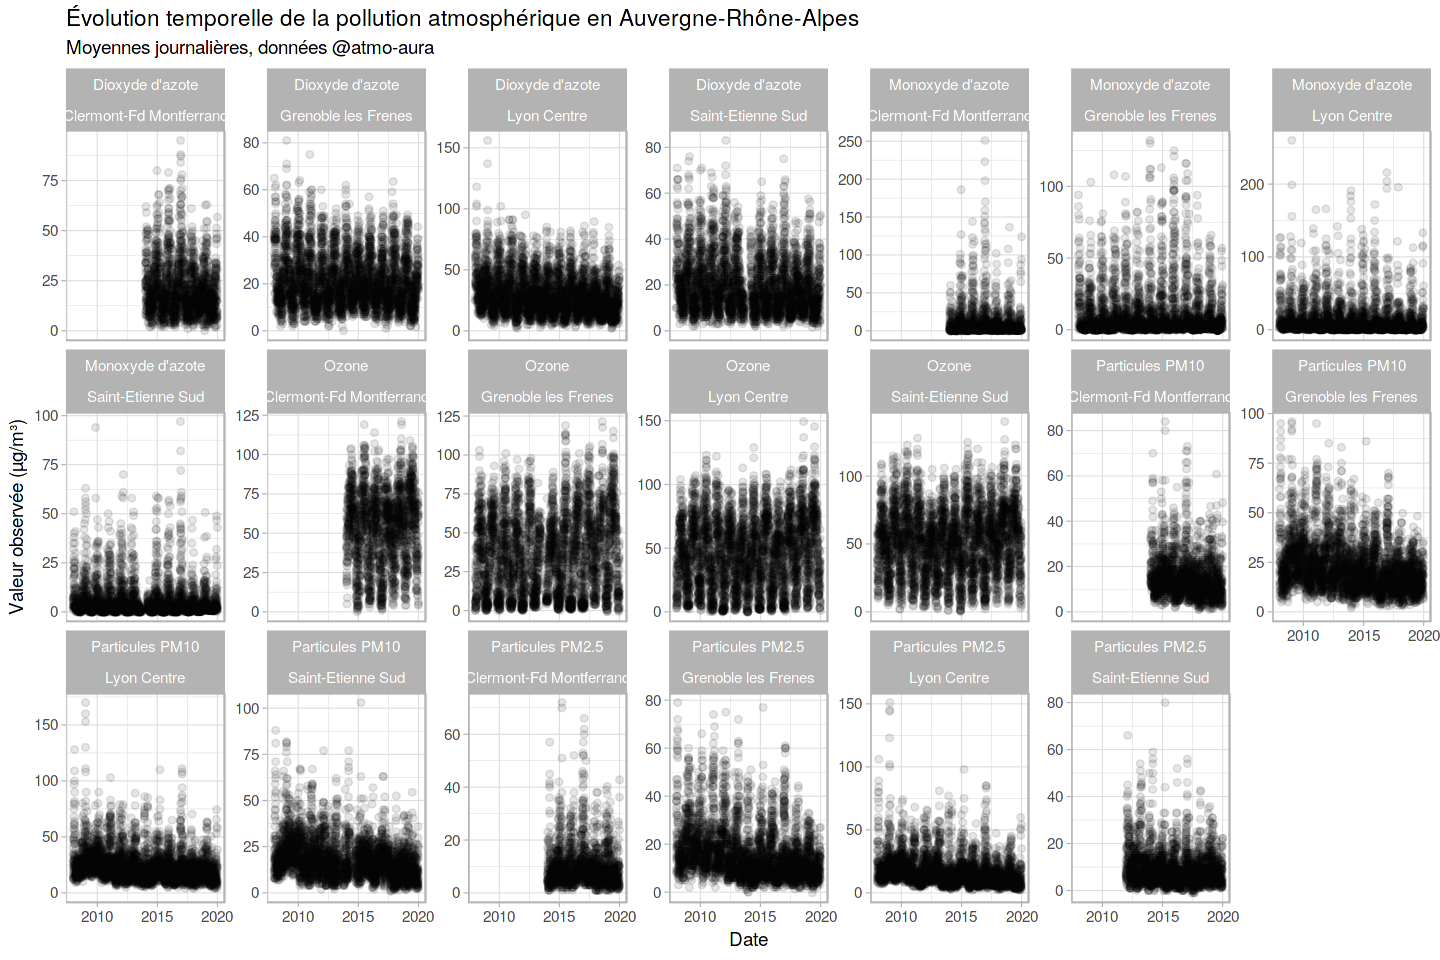

In [7]:
df %>% ggplot() +
    aes(x=Date, y=Valeur) +
    facet_wrap(c("Mesure", "Station"), scales='free_y', nrow=3) +
    geom_point(alpha=0.1) +
    theme_light() +
    expand_limits(y=0) +
    ylab("Valeur observée (µg/m³)") +
    ggtitle("Évolution temporelle de la pollution atmosphérique en Auvergne-Rhône-Alpes",
            subtitle="Moyennes journalières, données @atmo-aura")

On applique une moyenne roulante sur 30 jours pour "lisser" un peu les données dans la visualisation.

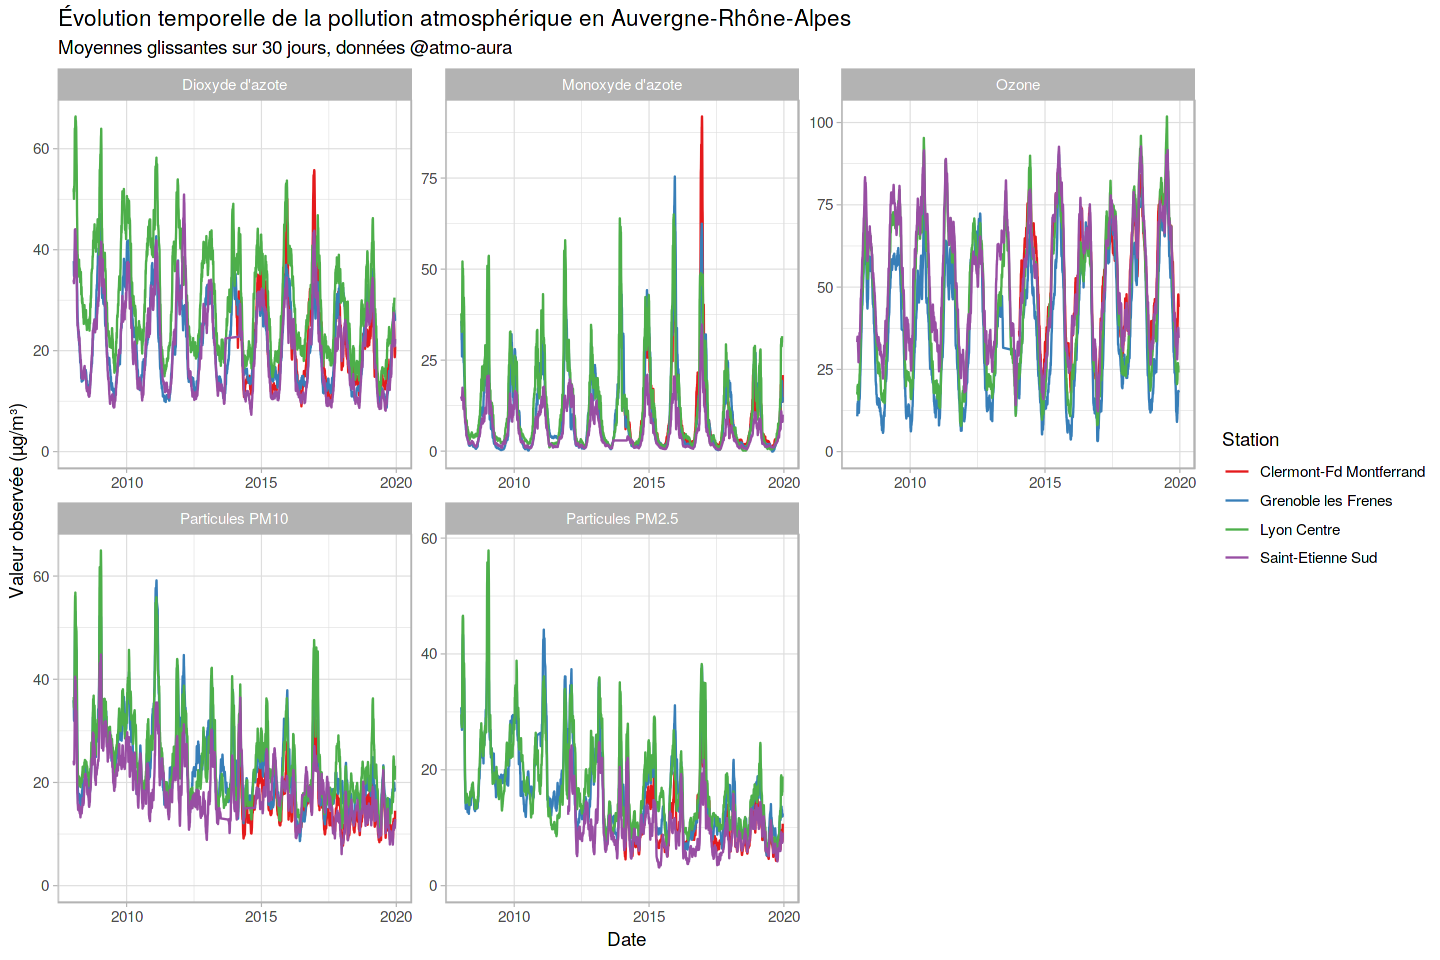

In [8]:
width = 30
df %>%
    group_by(Station, Mesure) %>%
    mutate(avg=rollapply(Valeur, width, mean, fill=NA)) %>%
    drop_na() %>%
    ungroup() %>%
    ggplot() +
        aes(x=Date, y=avg, color=Station) +
        facet_wrap(c("Mesure"), scales='free') +
        geom_line() +
        theme_light() +
        scale_color_brewer(palette="Set1") +
        expand_limits(y=0) +
        ylab("Valeur observée (µg/m³)") +
        ggtitle("Évolution temporelle de la pollution atmosphérique en Auvergne-Rhône-Alpes",
               subtitle="Moyennes glissantes sur 30 jours, données @atmo-aura")

## Évolution annuelle du taux moyen

Toujours assez difficile de distinguer quelque chose. On va calculer la moyenne annuelle de chaque année.

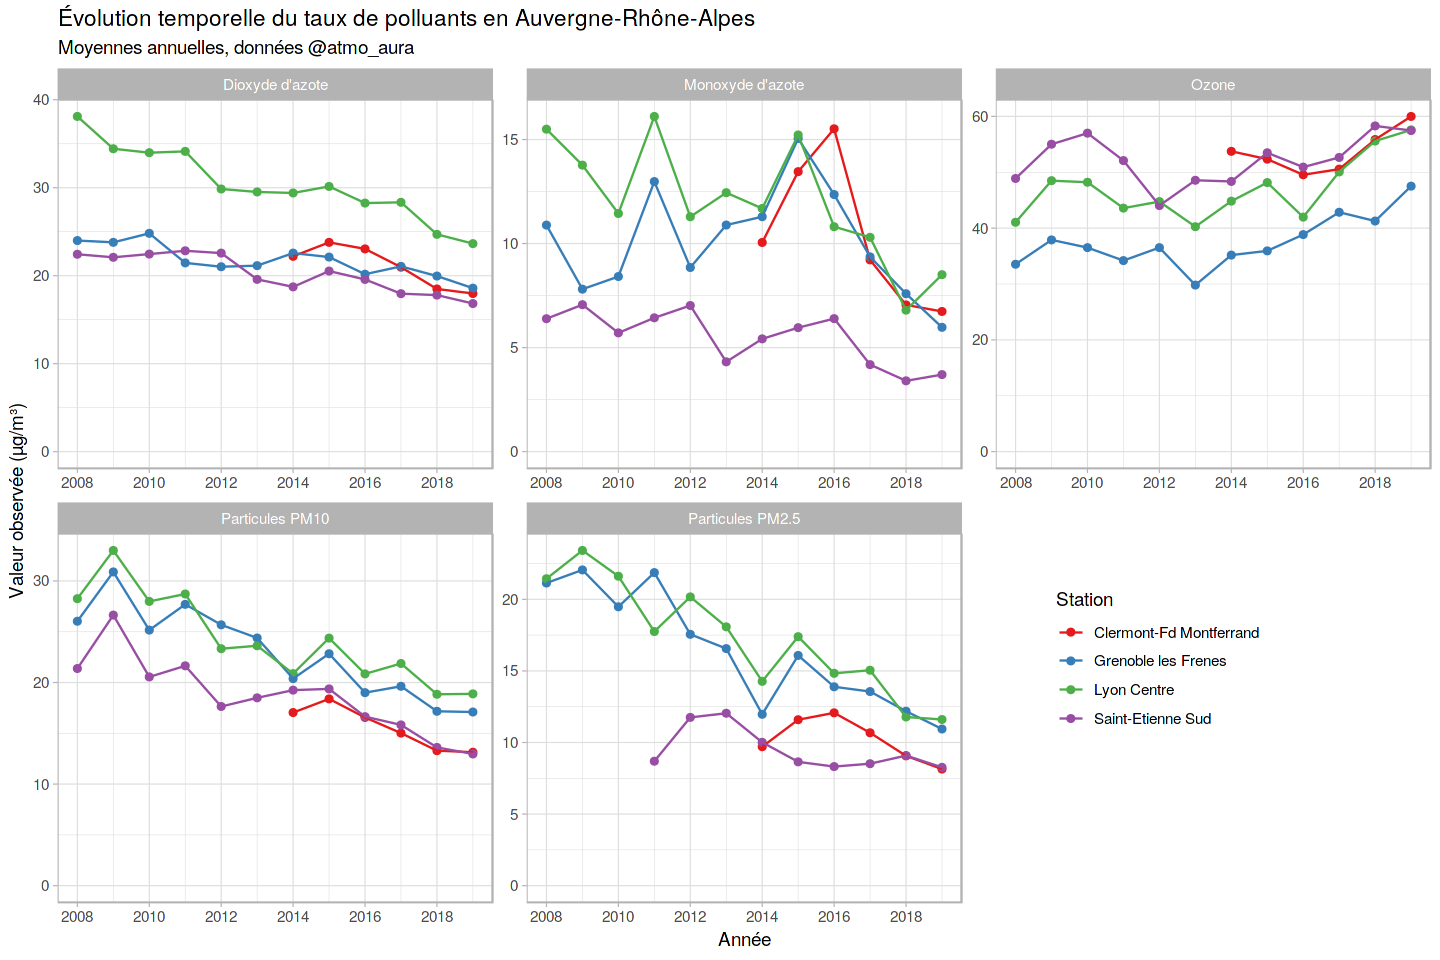

In [9]:
df %>%
    mutate(Annee=year(Date)) %>%
    group_by(Annee, Station, Mesure) %>%
    summarise(avg=mean(Valeur)) %>%
    ungroup() %>%
    ggplot() +
        aes(x=Annee, y=avg, color=Station) +
        facet_wrap("Mesure", scales='free') +
        geom_point() +
        geom_line() +
        expand_limits(y=0) +
        theme_light() +
        scale_x_continuous(breaks=seq(2008,2019,2)) +
        scale_color_brewer(palette="Set1") +
        xlab("Année") +
        ylab("Valeur observée (µg/m³)") +
        theme(legend.position=c(0.8, 0.3)) +
        ggtitle("Évolution temporelle du taux de polluants en Auvergne-Rhône-Alpes",
                subtitle="Moyennes annuelles, données @atmo_aura")

Maintenant la même figure, mais en base 100 avec 2014 comme référence.

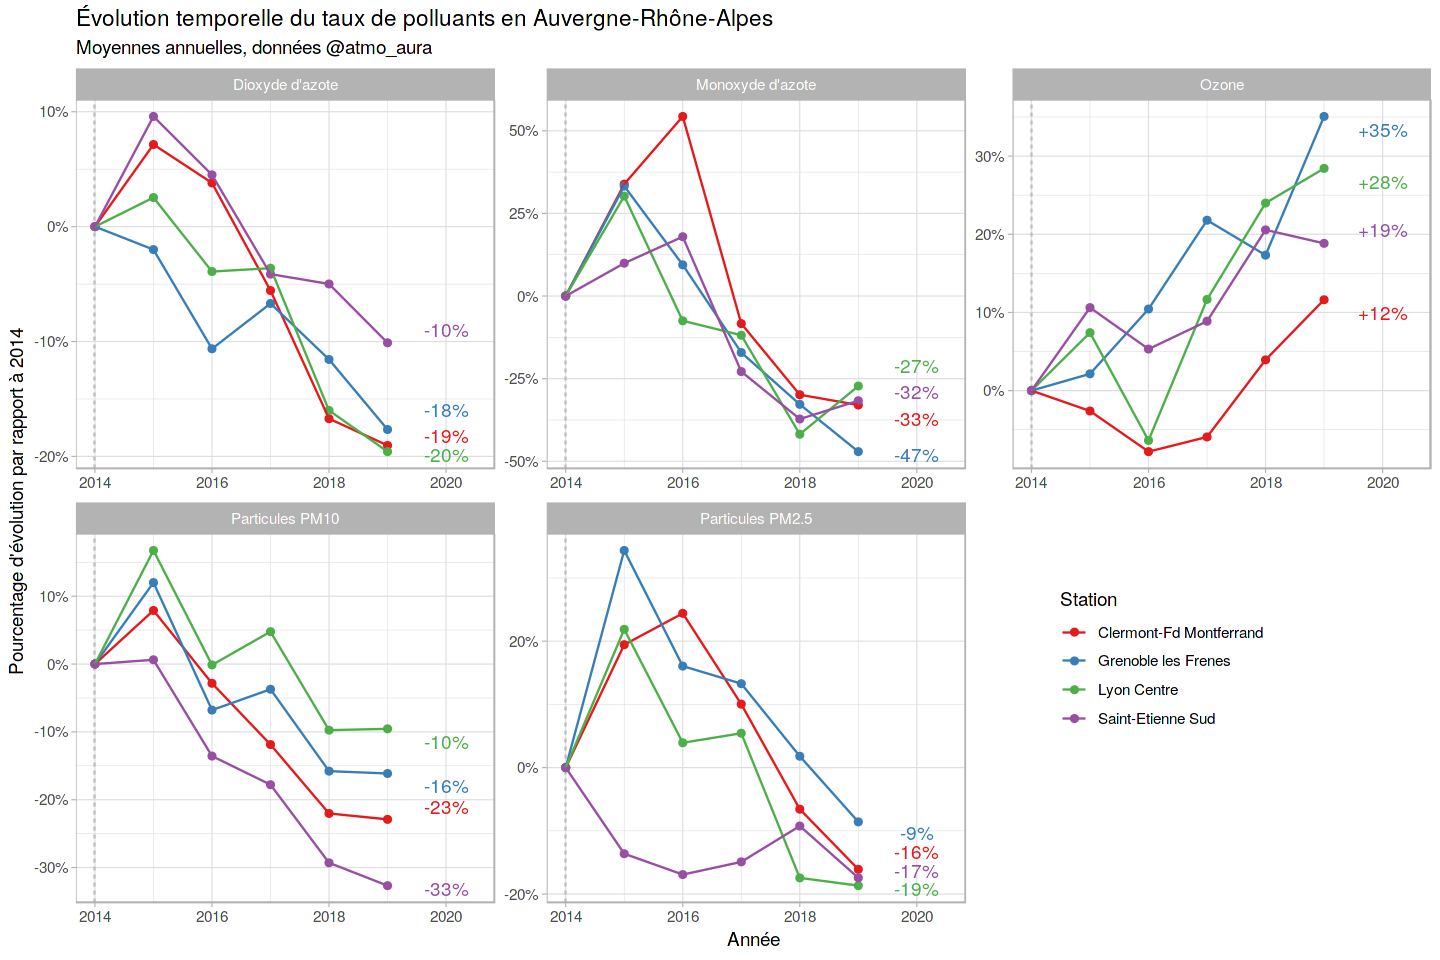

In [10]:
set.seed(42)  # deterministic geom_text_repel
ref_year=2014

df %>%
    mutate(Annee=year(Date)) %>%
    group_by(Annee, Station, Mesure) %>%
    summarise(avg=mean(Valeur)) %>%
    ungroup() %>%
    full_join(filter(., Annee==ref_year), by=c("Station", "Mesure"), suffix=c("", "_ref")) %>%
    mutate(ratio=avg/avg_ref-1) %>%
    mutate(text=round(ratio*100, 0)) %>%
    mutate(text=paste(ifelse(ratio > 0, "+", ""), text,"%", sep="")) %>%
    filter(Annee >= ref_year) %>% {(
    ggplot(.) +
        aes(x=Annee, y=ratio, color=Station) +
        facet_wrap("Mesure", scales='free') +
        geom_vline(xintercept=ref_year, linetype="dashed", color="gray") +
        geom_point() +
        geom_line() +
        geom_text_repel(data=filter(., Annee==2019) %>% mutate(Annee=2020), aes(label=text), direction="y", segment.alpha=0, show.legend=F) +
        expand_limits(y=0, x=2020.5) +
        theme_light() +
        scale_x_continuous(breaks=seq(2008,2020,2)) +
        scale_y_continuous(labels = scales::percent_format(accuracy=1)) +
        scale_color_brewer(palette="Set1") +
        xlab("Année") +
        ylab(paste("Pourcentage d'évolution par rapport à", ref_year)) +
        theme(legend.position=c(0.8, 0.3)) +
        ggtitle("Évolution temporelle du taux de polluants en Auvergne-Rhône-Alpes",
               subtitle="Moyennes annuelles, données @atmo_aura")
    )}

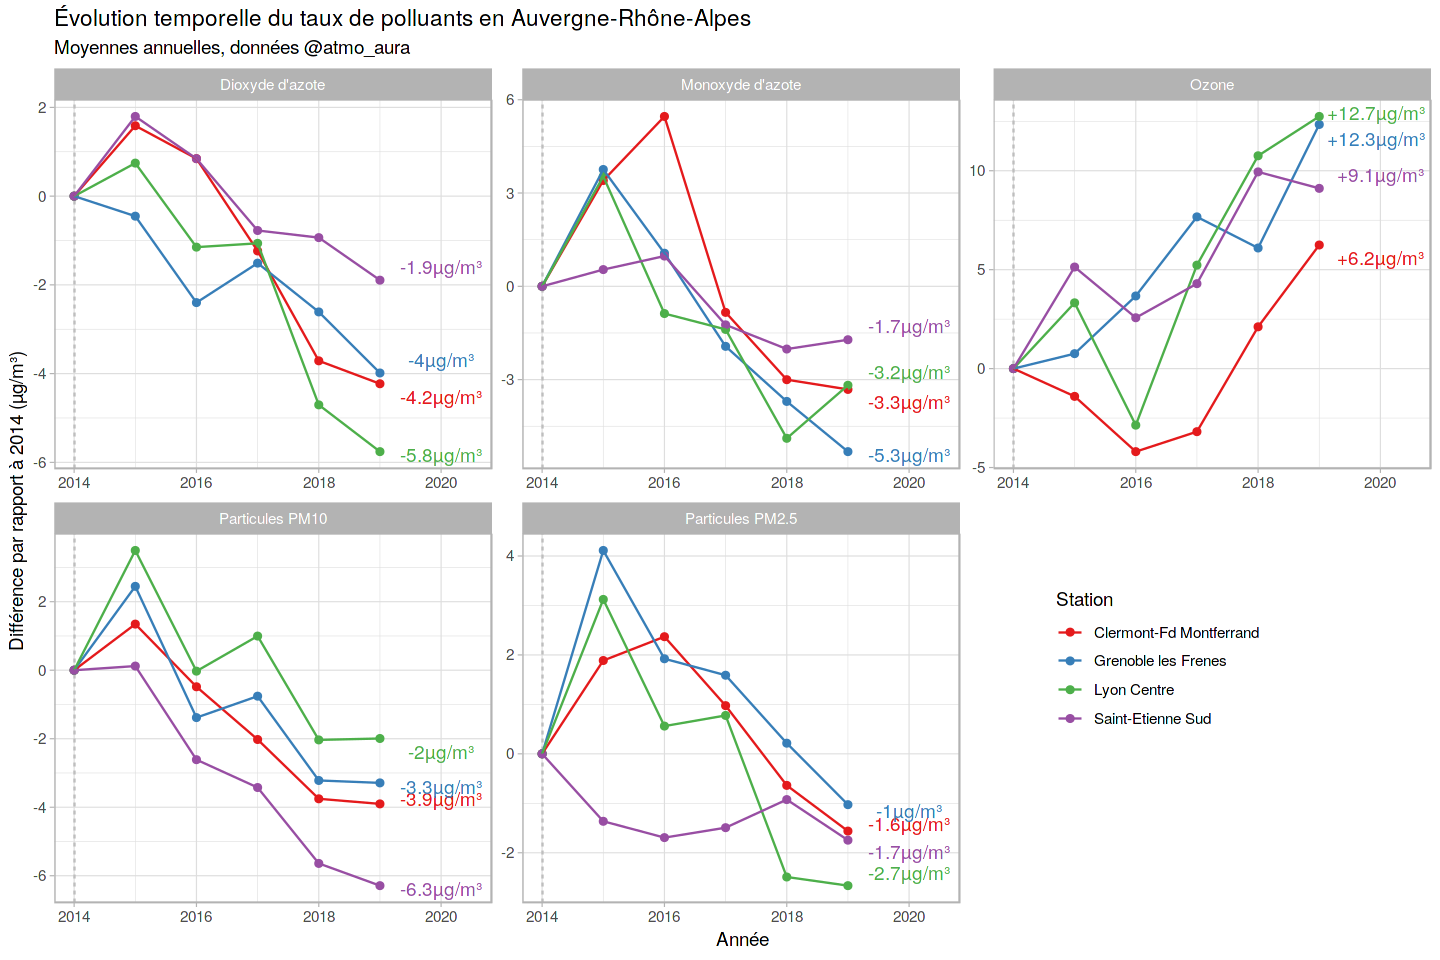

In [11]:
set.seed(42)  # deterministic geom_text_repel
ref_year=2014

df %>%
    mutate(Annee=year(Date)) %>%
    group_by(Annee, Station, Mesure) %>%
    summarise(avg=mean(Valeur)) %>%
    ungroup() %>%
    full_join(filter(., Annee==ref_year), by=c("Station", "Mesure"), suffix=c("", "_ref")) %>%
    mutate(diff=avg-avg_ref) %>%
    mutate(text=round(diff, 1)) %>%
    mutate(text=paste(ifelse(diff > 0, "+", ""), text,"µg/m³", sep="")) %>%
    filter(Annee >= ref_year) %>% {(
    ggplot(.) +
        aes(x=Annee, y=diff, color=Station) +
        facet_wrap("Mesure", scales='free') +
        geom_vline(xintercept=ref_year, linetype="dashed", color="gray") +
        geom_point() +
        geom_line() +
        geom_text_repel(data=filter(., Annee==2019) %>% mutate(Annee=2020), aes(label=text), direction="y", segment.alpha=0, show.legend=F) +
        expand_limits(y=0, x=2020.5) +
        theme_light() +
        scale_x_continuous(breaks=seq(2008,2020,2)) +
        scale_color_brewer(palette="Set1") +
        xlab("Année") +
        ylab(paste("Différence par rapport à", ref_year, "(µg/m³)")) +
        theme(legend.position=c(0.8, 0.3)) +
        ggtitle("Évolution temporelle du taux de polluants en Auvergne-Rhône-Alpes",
               subtitle="Moyennes annuelles, données @atmo_aura")
    )}

## Évolution annuelle du nombre de jours au dessus du seuil

Différentes valeurs à ne pas dépasser sur 24h sont listées [sur ce site](https://www.airparif.asso.fr/reglementation/recommandations-oms) :
- 50µg/m³ pour les particules PM10
- 25µg/m³ pour les particules PM2.5

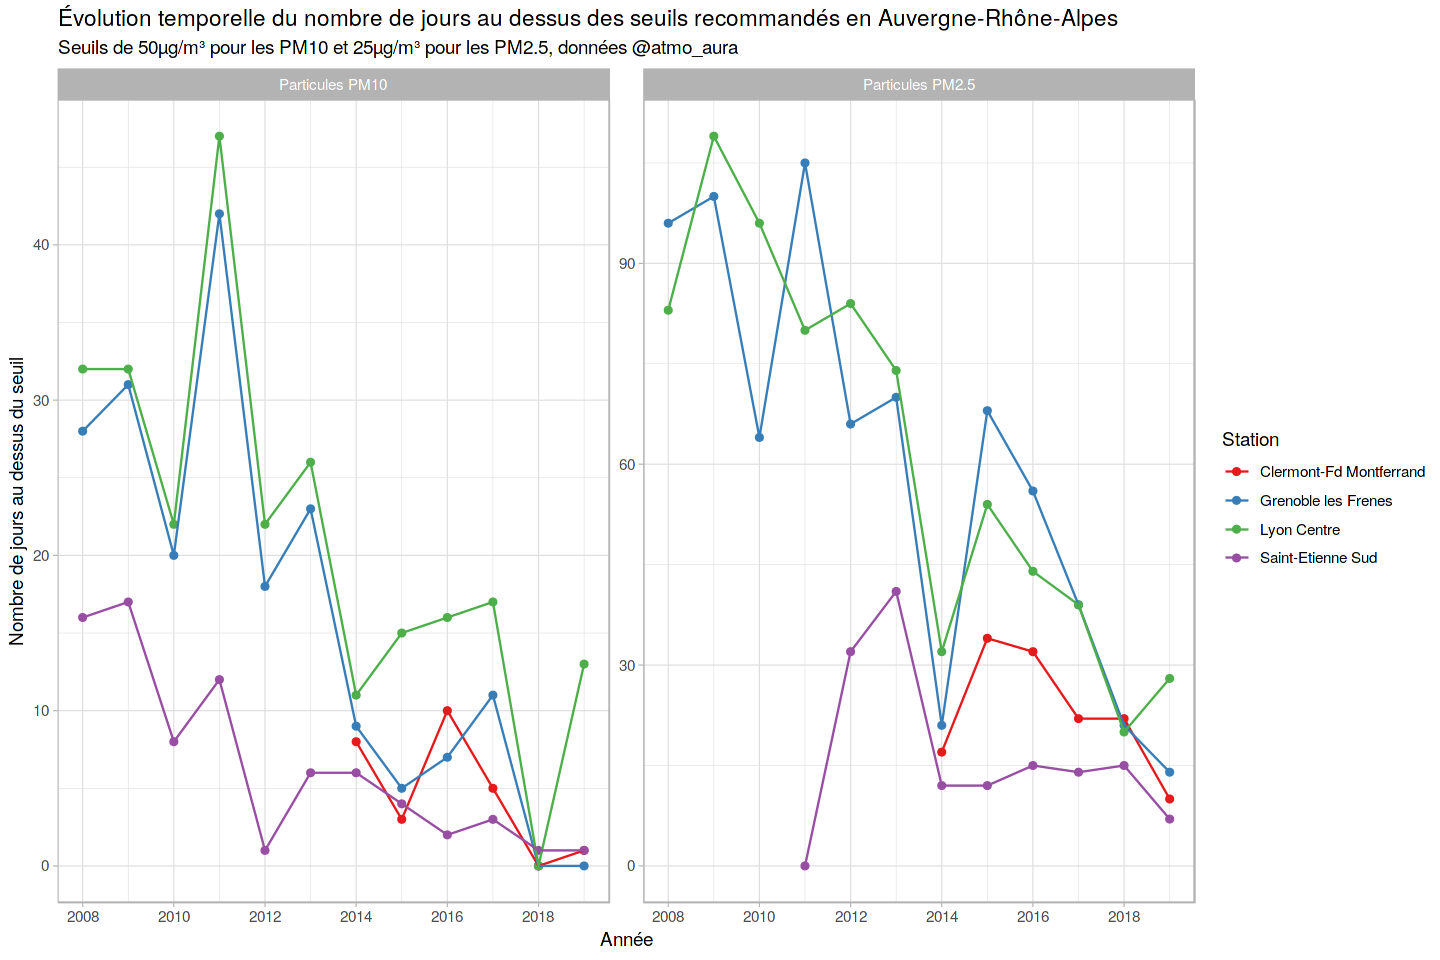

In [12]:
df %>%
    mutate(Annee=year(Date)) %>%
    filter(Mesure %in% c("Particules PM10", "Particules PM2.5")) %>%
    mutate(threshold = ifelse(Mesure == "Particules PM10", 50, 25)) %>%
    mutate(above_thresh=ifelse(Valeur >= threshold, 1, 0)) %>%
    group_by(Annee, Station, Mesure) %>%
    summarise(nb=sum(above_thresh)) %>%
    ungroup() %>%
    ggplot(.) +
        aes(x=Annee, y=nb, color=Station) +
        facet_wrap("Mesure", scales='free') +
        geom_point() +
        geom_line() +
        expand_limits(y=0) +
        theme_light() +
        scale_x_continuous(breaks=seq(2008,2020,2)) +
        scale_color_brewer(palette="Set1") +
        xlab("Année") +
        ylab(paste("Nombre de jours au dessus du seuil")) +
        ggtitle("Évolution temporelle du nombre de jours au dessus des seuils recommandés en Auvergne-Rhône-Alpes",
               subtitle="Seuils de 50µg/m³ pour les PM10 et 25µg/m³ pour les PM2.5, données @atmo_aura")